# `Darts` Show & Tell – Example

## Notebook setup

In [33]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import InvertibleMapper
from darts.metrics import mape

## The dataset

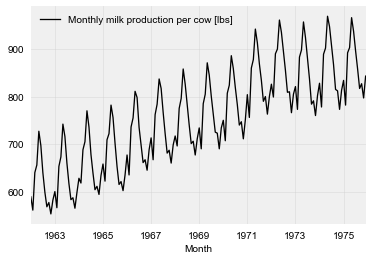

            Pounds per cow
Month                     
1962-01-01             589
1962-02-01             561
1962-03-01             640
1962-04-01             656
1962-05-01             727
...                    ...
1975-08-01             858
1975-09-01             817
1975-10-01             827
1975-11-01             797
1975-12-01             843

[168 rows x 1 columns]
Freq: MS


In [35]:
df = pd.read_csv('monthly-milk.csv')
series = TimeSeries.from_dataframe(df, time_col='Month', value_cols=['Pounds per cow'])

series.plot(label="Monthly milk production per cow [lbs]")
plt.legend()
plt.show()

print(series)

## Splitting the dataset and making a simple prediction

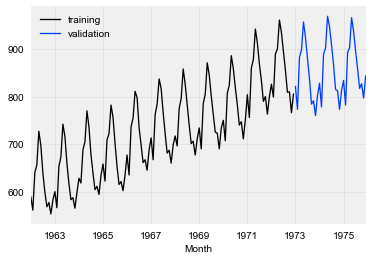

In [36]:
training, validation = series.split_before(pd.Timestamp('1973-01-01'))

training.plot(label="training")
validation.plot(label="validation")
plt.legend()
plt.show()

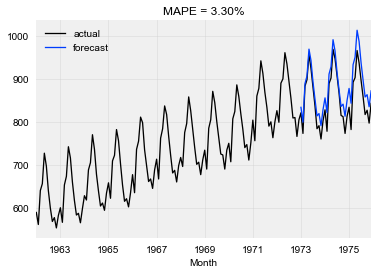

In [37]:
model = ExponentialSmoothing()
model.fit(training)
forecast = model.predict(36)

series.plot(label='actual')
forecast.plot(label='forecast')

plt.title('MAPE = {:.2f}%'.format(mape(forecast, validation)))
plt.legend()
plt.show()

### Can we do better ? Yes! By making the time series simpler using a nice trick

Instead of looking at monthly aggregated data, we can look at the *daily average production*

## A smoother time series using `InvertibleMapper`

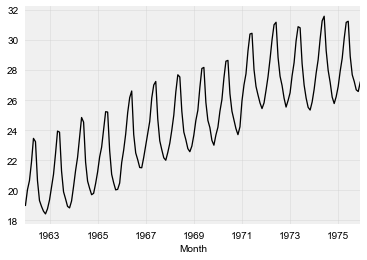

In [38]:
toDailyAverage = InvertibleMapper(fn=lambda timestamp, x: x/timestamp.days_in_month,
                                  inverse_fn=lambda timestamp, x: x*timestamp.days_in_month)

dailyAverage = toDailyAverage.transform(series)

dailyAverage.plot()
plt.show()

## Splitting the dataset and making a prediction – again

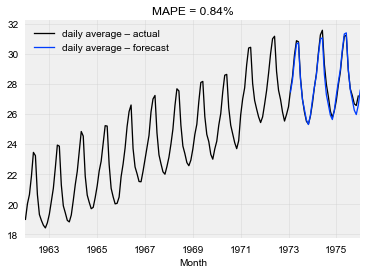

In [39]:
dailyavg_train, dailyavg_val = dailyAverage.split_after(pd.Timestamp('1973-01-01'))

model = ExponentialSmoothing()
model.fit(dailyavg_train)
dailyavg_forecast = model.predict(36)

dailyAverage.plot(label="daily average – actual")
dailyavg_forecast.plot(label="daily average – forecast")

plt.title('MAPE = {:.2f}%'.format(mape(dailyavg_forecast, dailyavg_val)))
plt.legend()
plt.show()

### Woo-hoo we've made it! But I wanted the monthly production per cow, not the daily average…

## Going back to the original series using `inverse_transform()`

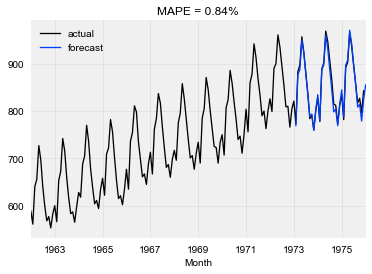

In [40]:
forecast = toDailyAverage.inverse_transform(dailyavg_forecast)

series.plot(label='actual')
forecast.plot(label='forecast')

plt.title('MAPE = {:.2f}%'.format(mape(forecast, validation)))
plt.legend()
plt.show()